In [1]:
from disk_utils_jax import jax_model, jax_model_scal
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np

from jaxopt import ScipyMinimize

## Defining Disk and SPF Parameters

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
disk_params2 = {}
disk_params2['inclination'] = 40. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [4]:
# Scattering Phase Function Parameters
spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

## Creating Disk Models

In [5]:
# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})
end = datetime.now()
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params2,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

2024-06-19 22:30:25.090351: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


0:00:04.357653
0:00:00.000615


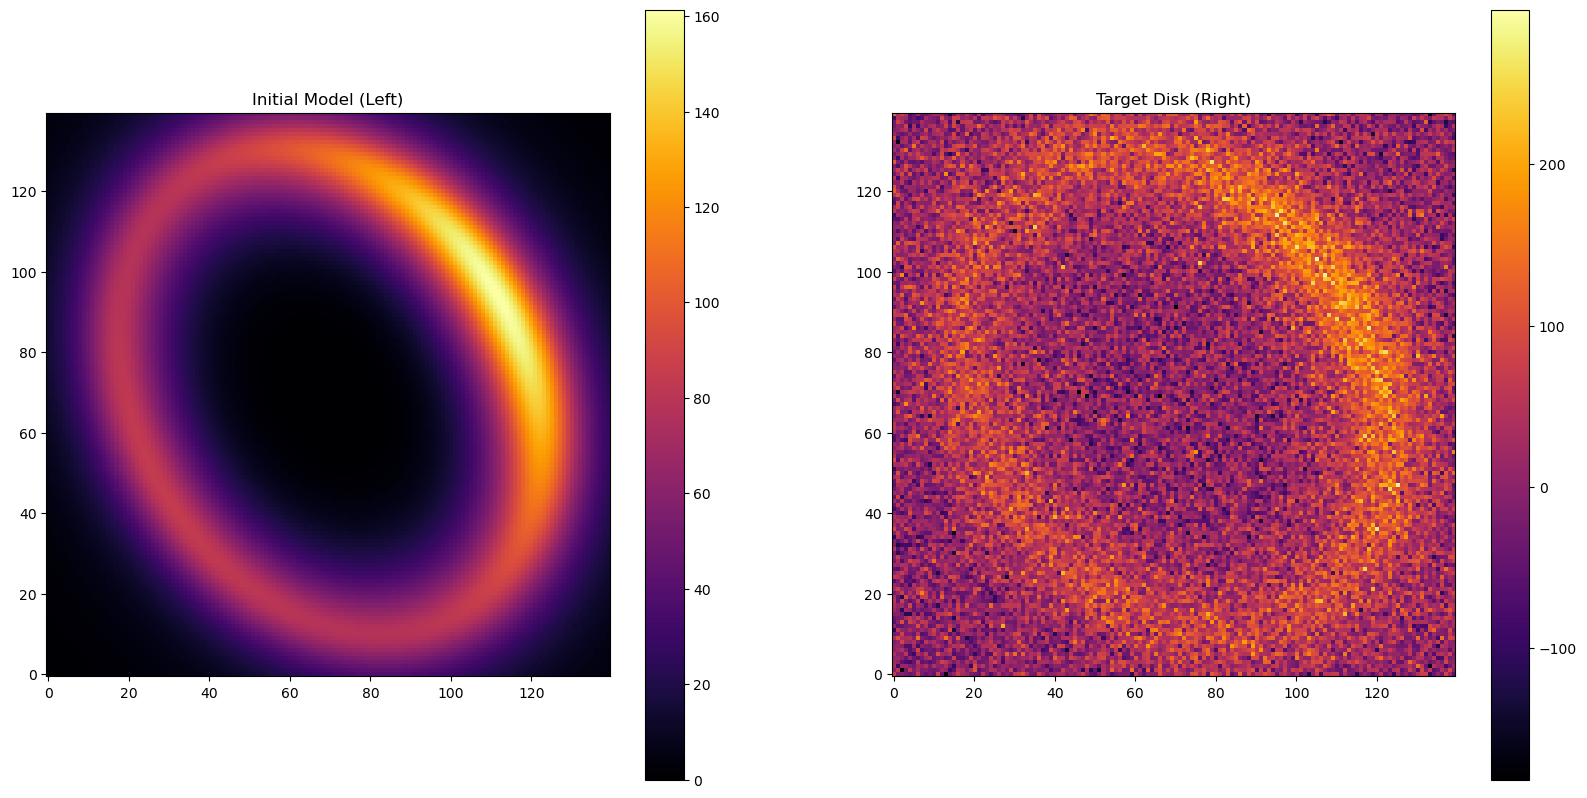

In [9]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

## Running Optimizations with more Parameters

In [27]:
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

# initial spf params, 0: g1, 1: g2, 2: weight
spf_params_jax = jnp.array([0.5, -0.5, 0.5])

all_pars = jnp.concatenate((disk_params_1d_jax, spf_params_jax))

In [28]:
from regression import log_likelihood_1d_pos_all_pars

llp = lambda x: log_likelihood_1d_pos_all_pars(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
soln_sm, ignore = solver.run(init_params=all_pars)

disk_fit_jaxopt = {'alpha_in': soln_sm[0], 'alpha_out': soln_sm[1], 'sma': soln_sm[2], 'inclination': soln_sm[3], 'position_angle': soln_sm[4]}


### Likelihood Results

In [ ]:
print("JAX Optimization Disk Parameters: " + str(disk_fit_jaxopt) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_sm, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 40.07572642460924, 'position_angle': 30.67529158645408, 'alpha_in': 5.157047611482366, 'alpha_out': -6.882015698166157, 'flux_scaling': 1000000.0, 'sma': 39.935074430139764}{'g1': Array(0.49801475, dtype=float64), 'g2': Array(-0.29552539, dtype=float64), 'weight': Array(0.70298002, dtype=float64)}
Log-Likelihood: 86417.95570603193
Gradient Optimization Disk Parameters: {'inclination': 40.178709285770196, 'position_angle': 30.557653517431575, 'alpha_in': 5.163410525571317, 'alpha_out': -6.841766942953095, 'flux_scaling': 1000000.0, 'sma': 39.941875285897616}{'g1': Array(0.49991815, dtype=float64), 'g2': Array(-0.29086267, dtype=float64), 'weight': Array(0.70097086, dtype=float64)}
Log-Likelihood: 86417.9005238699
JAX Optimization Disk Parameters: {'inclination': Array(40.17898459, dtype=float64), 'position_angle': Array(30.55676541, dtype=float64), 'alpha_in': Array(5.16348474, dtype=float64), 'alpha_out': Array(-6.84188251, dtyp

### Image Comparisions

In [ ]:
spf_params_jaxopt = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])

disk_image_fit_jaxopt = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_jaxopt,
                               spf_params=spf_params_jaxopt)

Text(0.5, 1.0, 'JaxOpt Optimized Disk')

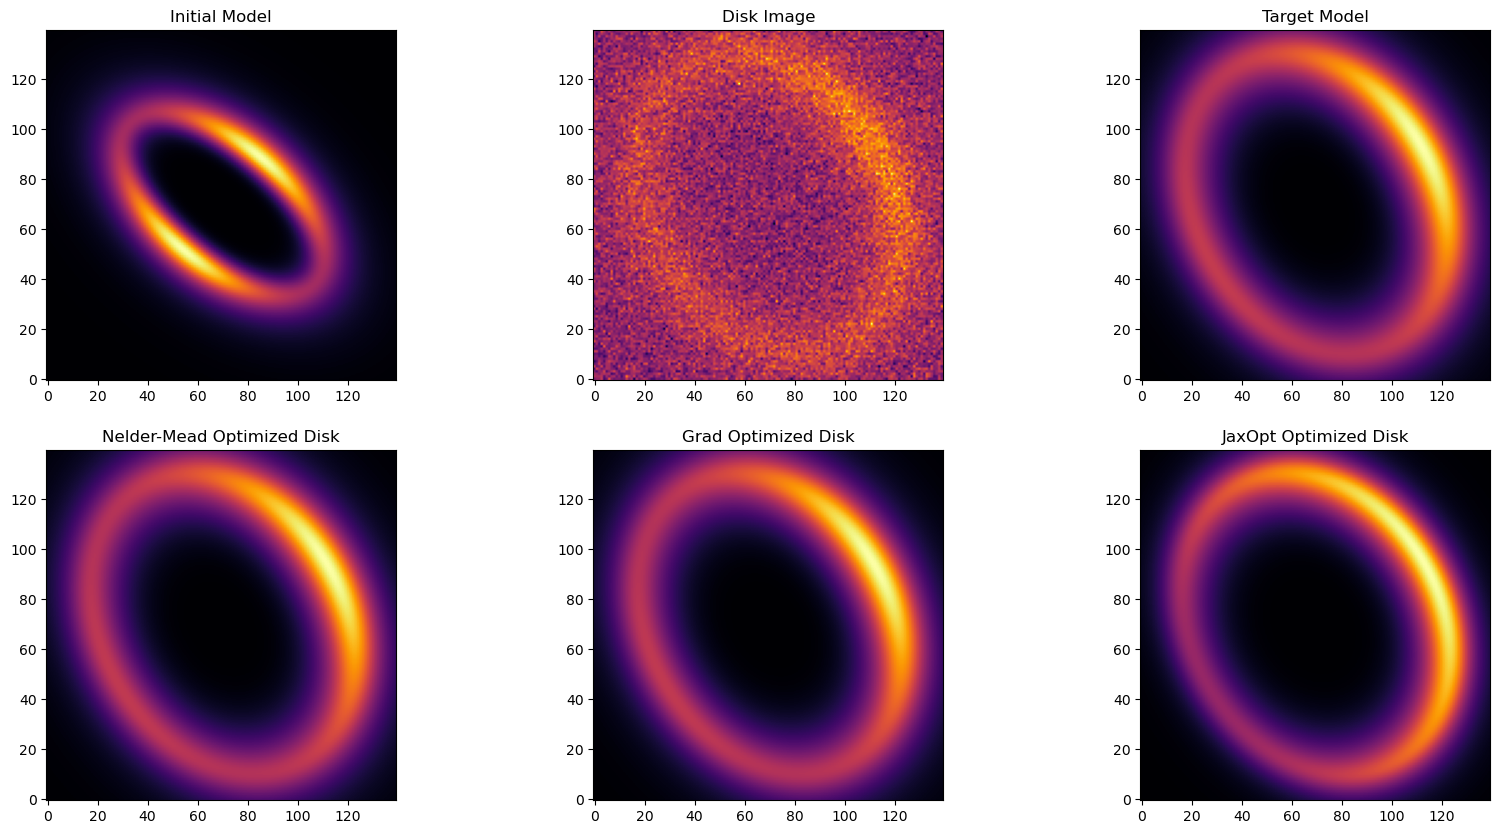

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

axes[0][0].imshow(disk_image1_ap, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[1][0].imshow(disk_image_fit_jaxopt, origin='lower', cmap='inferno')
axes[1][0].set_title("JaxOpt Optimized Disk")

axes[1][1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1][1].set_title("Target Model")

In [ ]:
norm_solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
def jax_optimization_test_norm():
    res = norm_solver.run(init_params=all_pars)

#### Testing Runtimes

In [ ]:
%timeit nelder_mead_test()
%timeit gradient_optimization_test()
#%timeit jax_optimization_test()
%timeit jax_optimization_test_norm()

3.78 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.46 s ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.98 s ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
